(sec:reinforcement-learning)=
# 強化学習の基礎

強化学習とは、何らかの目的を達成するために、「行動」と「評価」を繰り返しながら、より良い行動を取ることを目指す機械学習法である。

これまで取り扱ってきた教師あり学習が「正解に近づく」ように学習を行うのに対し、強化学習は、**報酬が最大となる**ように学習を行う。

今回は、「多腕バンディット問題」を題材に、強化学習の基礎について紹介する。

In [1]:
"""
下準備のコード
"""

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")

## 多腕バンディット問題

**多腕バンディット問題**とは、スロットゲームを題材に、得られる報酬の量を最大にする問題である。今、スロットが複数台あり、それぞれがどの程度の確率で当たりを出すかは未知である。このような状況下で、スロットを決まった回数だけ回して、当たり確率を推定しながら、より多くの当たりを出すスロットを回す。

この問題では、**当たり確率の推定精度を上げる**ことと、**当たりが多く出そうなスロットを回す**という二つの問題を同時に解く必要がある。本資料では、これらの目的を目指す行動を、それぞれ**探査**と**知識利用**と呼ぶ。

探査と知識利用は、相反する行動で、より当たり確率の推定精度を上げようとすれば、例えば、一見当たりが出なさそうにみえるスロットも、もう少し回した方が良い可能性がある。一方で、推定精度の向上に拘泥しすぎると、当たりが多く出そうなスロットを回す回数が減ってしまい、結果として得られる報酬が減ってしまう。

### スロットゲームの実装

まずは、多腕バンディット問題を扱うために、スロットゲームを実装してみる。スロット台のアームを表わす `SlotArm`というクラスを以下のように実装する。

In [2]:
import numpy as np


class SlotArm(object):
    def __init__(self, ratio=0.5, seed=None):
        self.ratio = ratio
        self.rng = np.random.RandomState(seed)

    def roll(self):
        if self.rng.uniform(0.0, 1.0) < self.ratio:
            return True
        else:
            return False

この`SlotArm`クラスを配列として、スロット台を複数用意する。以下では、5台のスロット台を用意し、それらが当たりを出す確率が0.1から0.2刻みで0.9までであるとする (これは実際には未知の値である)。

In [3]:
n_arms = 5
ratios = np.linspace(0.1, 0.9, n_arms, endpoint=True)
ratios = np.random.permutation(ratios)
arms = [None] * n_arms
for i, ratio in enumerate(ratios):
    arms[i] = SlotArm(ratio=ratio)

n_play = 20000
xs = np.arange(n_play) + 1

### ランダムにスロットを回す

では、上記の問題設定で、ランダムに3つのスロット台のいずれかを回した場合に、どの程度の当たりが出るかを見てみよう。以下の実験では10万回スロットをプレイできるとして実験をしてみる。

In [4]:
history = []
for i in range(n_play):
    k = np.random.randint(0, n_arms)
    if arms[k].roll():
        history.append(1.0)
    else:
        history.append(0.0)

history = np.array(history)
accum = np.cumsum(history)
E_rand = accum / xs
S_rand = np.sqrt((history - E_rand) ** 2.0 / xs)

print("ratio = {:.3f}".format(E_rand[-1]))

ratio = 0.497


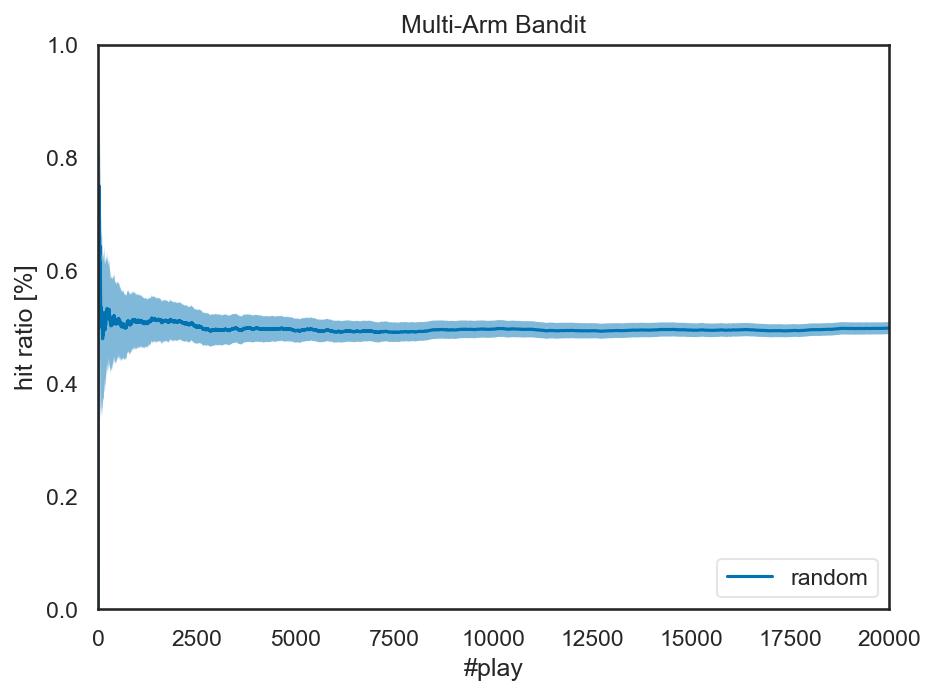

In [5]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

この結果から分かる通り、ランダムに回す場合には、得られる報酬は、当たり確率の平均値である$(0.3 + 0.8 + 0.4) / 3 = 0.5$程度に張り付いていることが分かる。回し方を工夫することで、この当たり確率を上げることをできるかがポイントとなる。

### 今一番当たっているスロットを回す

報酬を増やすためにあり得そうな方法は、今、一番当たっているスロットを常に回す、という方法である。この方式をWinner-Take-Allの頭文字からWTA方式と呼ぶこととする。

以下に、各スロットの現在の当たり確率を保存しておいて、それが最大になるものを回すようにプログラムを示す。ただし、最初の数回は当たり確率が安定しない可能性があるので、最初の10%は、ランダムに回している。

In [6]:
n_burnout = n_play // 10

history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    if i < n_burnout:
        k = np.random.randint(0, n_arms)
    else:
        rs = [(h / p if p != 0 else 1.0) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
        k = np.argmax(rs)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1

history = np.array(history)
accum = np.cumsum(history)
E_wta = accum / xs
S_wta = np.sqrt((history - E_wta) ** 2.0 / xs)

print("ratio = {:.3f}".format(E_wta[-1]))

ratio = 0.857


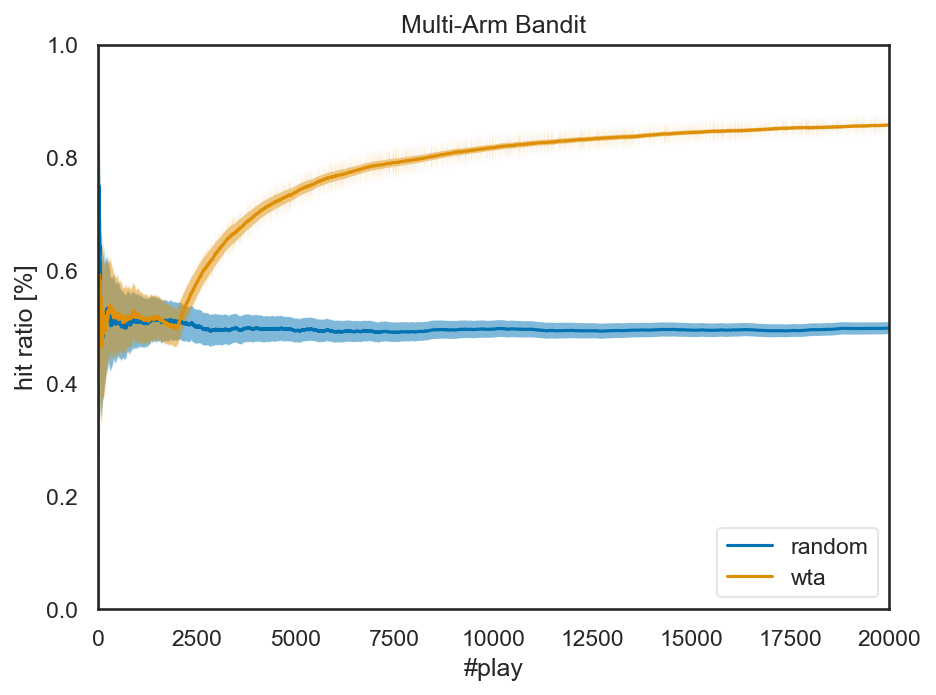

In [7]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_wta - S_wta * 3.0,
    E_wta + S_wta * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_wta, label="wta")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

一番当たっている物を回す、という戦略はそれほど悪くはないように見える。実際、最終的な報酬は、最も当たりやすいスロットの当たり確率である0.65に近づいている。

しかし、最初の10%を回した時点の当たり確率の推定値にその後の報酬が強く依存する上、10%の回数はランダムに回すことから、そこまでで得られる報酬は有意には増加しない。

## $\varepsilon$-greedy法

$\varepsilon$-greedy法は、とある定数$0 < \varepsilon < 1$について、$\varepsilon$の確率でランダムにスロットを選び、$1 - \varepsilon$の確率で一番当たっているスロットを回す、という方法である。

こうすることで、仮に最初の当たり確率推定値が間違っていたとしても、それを徐々に修正する力が働く。

In [8]:
epsilon = 0.1
n_burnout = n_play // 10

history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    u = np.random.uniform(0.0, 1.0)
    if u < epsilon:
        k = np.random.randint(0, n_arms)
    else:
        rs = [(h / p if p != 0 else 1.0) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
        k = np.argmax(rs)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1

history = np.array(history)
accum = np.cumsum(history)
E_eps = accum / xs
S_eps = np.sqrt((history - E_wta) ** 2.0 / xs)

print("ratio = {:.3f}".format(E_wta[-1]))

ratio = 0.857


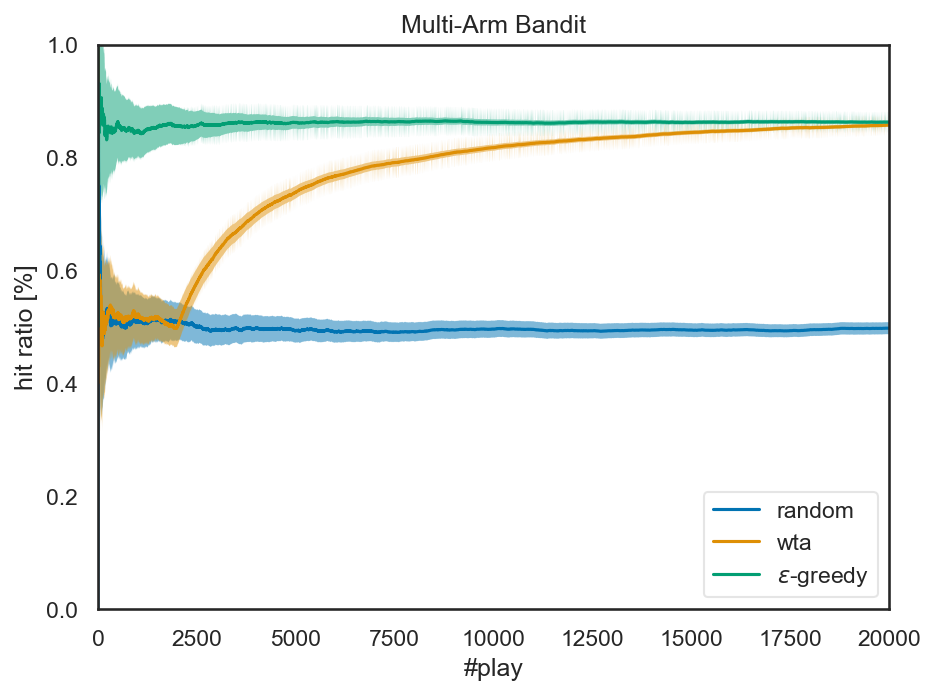

In [9]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_wta - S_wta * 3.0,
    E_wta + S_wta * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_wta, label="wta")

ax.fill_between(
    xs,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_eps, label="$\epsilon$-greedy")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

このように、ちょっとした工夫を加えるだけで、かなり早い段階から最大の当たり確率である0.65に近い当たり確率が得られていることが分かる。

### ソフトマックス探索

$\varepsilon$-greedy法でも十分に良い結果が得られているが、探査のために完全なランダム行動を取る、という点には、まだ改善の余地がある。

例えば、スロットの当たり確率が0.05のスロットも、この時にランダムに選ばれてしまう点はマイナスである。

そこで、ランダムな探査の代わりに、現在の推定当たり確率から求まる評価関数によって、探査行動の選択を考える。このような評価関数の一つにソフトマックス関数がある。

ソフトマックス関数は[深層学習による機械分類](sec:deep-learning)の際にも紹介した。今回は、$i$番目のスロットに対して求まっている当たり確率の期待値が$x_i$であるとしたときに、スロットの評価値$v_i$を以下のように定義する。

$$
v_i = \frac{e^{x_i}}{\sum_{i=1}^N e^{x_i}}
$$

ソフトマックス関数により得られる評価値は0から1の間の実数を取り、全てのスロットの評価値の合計は1となる。この時、仮に当たり確率の期待値が0であっても、ある程度の割合で選択され、一方で、確率としては、より当たり確率が高いものを相対的に多く選ぶという意味で、ランダム性と当たり確率の利用のバランスが良い。

In [10]:
epsilon = 0.1
n_burnout = n_play // 10


def softmax(x):
    x = x - np.max(x, axis=0)
    return np.exp(x) / np.sum(np.exp(x), axis=0)


history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    rs = [(h / p if p != 0 else 1e5) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
    rs = softmax(rs)

    u = np.random.uniform(0.0, 1.0)
    if u < epsilon:
        k = np.random.choice(np.arange(n_arms), p=rs)
    else:
        k = np.argmax(rs)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1

history = np.array(history)
accum = np.cumsum(history)
E_smax = accum / xs
S_smax = np.sqrt((history - E_wta) ** 2.0 / xs)

print("ratio = {:.3f}".format(E_wta[-1]))

ratio = 0.857


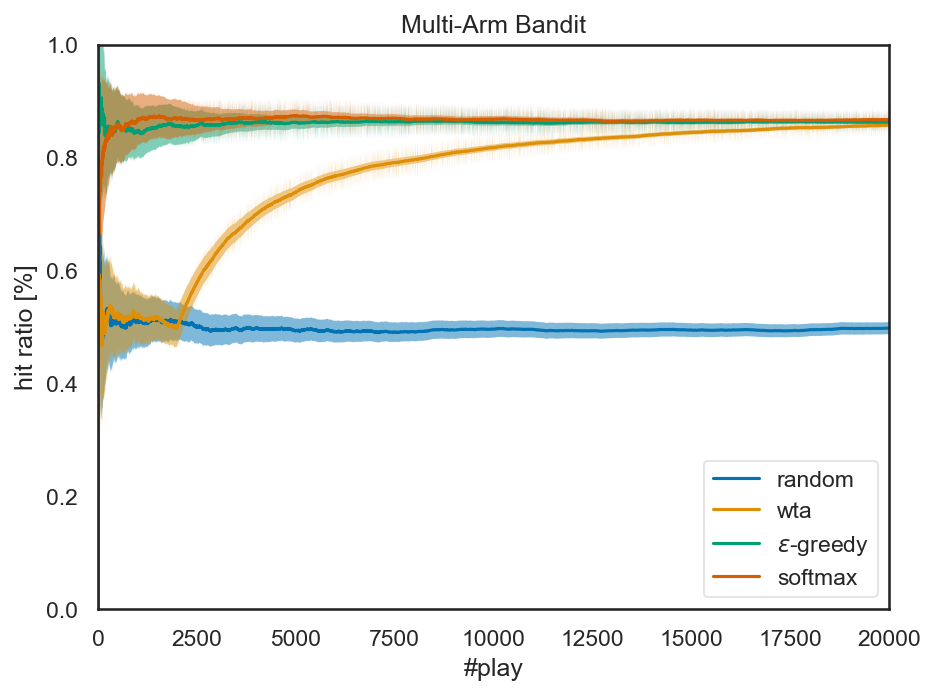

In [11]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_wta - S_wta * 3.0,
    E_wta + S_wta * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_wta, label="wta")

ax.fill_between(
    xs,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_eps, label="$\epsilon$-greedy")

ax.fill_between(
    xs,
    E_smax - S_smax * 3.0,
    E_smax + S_smax * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_smax, label="softmax")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

## Upper Confidence Bound (UCB)

先ほどのソフトマックス探索

In [12]:
history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    if min(n_play_of_arm) == 0:
        k = np.random.choice([j for j, n in enumerate(n_hit_of_arm) if n == 0])
    else:
        rs = [(h / p if p != 0 else 1e5) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
        bws = np.sqrt(2.0 * np.log(i) / np.array(n_play_of_arm))
        ucb = rs + bws
        k = np.argmax(ucb)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1

history = np.array(history)
accum = np.cumsum(history)
E_ucb = accum / xs
S_ucb = np.sqrt((history - E_wta) ** 2.0 / xs)

print("ratio = {:.3f}".format(E_wta[-1]))

ratio = 0.857


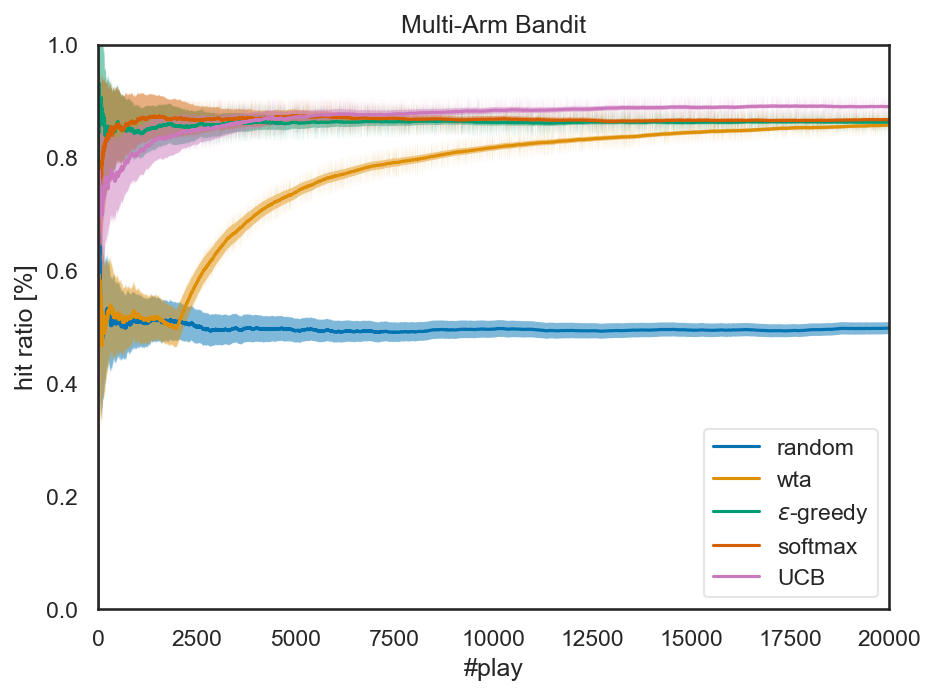

In [13]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_wta - S_wta * 3.0,
    E_wta + S_wta * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_wta, label="wta")

ax.fill_between(
    xs,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_eps, label="$\epsilon$-greedy")

ax.fill_between(
    xs,
    E_smax - S_smax * 3.0,
    E_smax + S_smax * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_smax, label="softmax")

ax.fill_between(
    xs,
    E_ucb - S_ucb * 3.0,
    E_ucb + S_ucb * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_ucb, label="UCB")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

## 練習問題

- UCBにはいくつかの種類があり、本資料で紹介したものはUCB1と呼ばれる。UCB2やUCB1-tunedと呼ばれる評価関数について調査し、その性能をUCB1と比較せよ。